# Анализ поведения пользователей мобильного приложения.

Наша команда аналитиков вместе с отделом маркетинга захотели проверить повлияет ли изменение шрифта в приложении стартапа, который продаёт продукты питания. Задачи проекта — изучить воронку продаж и проанализировать результаты A/A/B-теста. В нашем распоряжении имеются данные:

* Записи в логе о действиях или событиях пользователей


# План работы

**1. Загрузка данных и подготовка их к анализу.**

* Посмотреть первые строки
* Обработать пропуски
* Обработать дубликаты
* Посмотреть на тип данных столбцов

**2. Анализ данных.**

* Сколько всего событий в логе
* Сколько всего пользователей в логе?
* Сколько в среднем событий приходится на пользователя?
* Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?
* Много ли событий и пользователей вы потеряли, отбросив старые данные?
* Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

**3. Анализ воронки событий.**

* Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.
* Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.
* Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.
* По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
* На каком шаге теряете больше всего пользователей?
* Какая доля пользователей доходит от первого события до оплаты?

**3. Анализ A/A/B-теста.**

* Сколько пользователей в каждой экспериментальной группе?
* Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.
* Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?
* Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?
* Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.


**4. Общий вывод**

* Написать выводы и принять решение по результатам теста. Варианты решений: 
    * Изменение шрифта на пользователей повлияло. 
    * Изменение шрифта на пользователей не повлияло.

# Описание данных


**Структура <code>logs_exp.csv</code>:**

* <code>EventName</code> — название события,
* <code>DeviceIDHash</code> — уникальный идентификатор пользователя,
* <code>EventTimestamp</code> — время события,
* <code>ExpId</code> — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

### Загрузка данных и подготовка их к анализу

In [1]:
import pandas as pd
import scipy.stats as st
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pandas.plotting import register_matplotlib_converters
 
register_matplotlib_converters()

In [2]:
try:
    df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
    
except:
    df = pd.read_csv('logs_exp.csv', sep='\t')
    
    
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:,.2f}'.format

display(df.head())

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [3]:
# общая информация о датафреймe logs_exp.csv
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Заметим, что нужно привести названия столбцов к змеимному стилю и переименовать, проверить датафреймы на дубликаты. Пропуски отсутствуют.

In [4]:
# переименуем столбцы в df
df = df.rename(columns={'EventName':'event', 
                        'DeviceIDHash':'user_id',
                        'EventTimestamp':'event_timestamp',
                        'ExpId':'group'
                               })

#### Столбец event

In [5]:
# посмотрим уникальные названия событий
df['event'].unique().tolist()

['MainScreenAppear',
 'PaymentScreenSuccessful',
 'CartScreenAppear',
 'OffersScreenAppear',
 'Tutorial']

С названиями событий все хорошо.

#### Столбец user_id

С данными все впорядке.

#### Столбец event_timestamp

Данные записаны в формате unix time. Создадим новые столбцы с датой и временем и просто с датой. 

In [6]:
# создаем столбец date_time
df['date_time'] = pd.to_datetime(df['event_timestamp'], unit='s')

# создаем столбец date_time
df['date'] = pd.to_datetime(df['date_time'].dt.date)

#### Столблец group

In [7]:
# посмотрим уникальные группы
df['group'].unique().tolist()

[246, 248, 247]

Каждый столбец обработан, теперь можно удалить явные дубликаты

In [8]:
# проверим данные на дубликаты
print(f'Количество явных дубликатов: {df.duplicated().sum()}')

# Посмотрим долю дубликатов в df и удалим их
print(f'Доля дубликатов: {df.duplicated().sum()/len(df)}')
df = df.drop_duplicates().reset_index(drop=True)

Количество явных дубликатов: 413
Доля дубликатов: 0.0016917493425526163


In [9]:
# общая информация df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event            243713 non-null  object        
 1   user_id          243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   group            243713 non-null  int64         
 4   date_time        243713 non-null  datetime64[ns]
 5   date             243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


Теперь данные готовы к анализу.

### Анализ данных

In [10]:
# посчитаем количество стобытий в логе и выведем их на экран
print(f'Количество событий в логе: {len(df)}')
print(f'Количество уникальных событий в логе: {len(df["event"].unique())}')
for i in df["event"].unique(): print(i)

Количество событий в логе: 243713
Количество уникальных событий в логе: 5
MainScreenAppear
PaymentScreenSuccessful
CartScreenAppear
OffersScreenAppear
Tutorial


In [11]:
# посчитаем уникальных пользователей в логе
print(f'Количество уникальных пользователей в логе: {df["user_id"].nunique()}')

Количество уникальных пользователей в логе: 7551


In [12]:
# посчитаем сколько всего событий приходится на пользователя
print(f'Количество событий в среднем приходится на пользователя: {round(len(df)/df["user_id"].nunique())}')

Количество событий в среднем приходится на пользователя: 32


In [13]:
# посчитаем минимальную и максимальную даты исследования
print(f'Минимальная дата исследования: {df["date"].min():%Y-%m-%d}')
print(f'Максимальная дата исследования: {df["date"].max():%Y-%m-%d}')

Минимальная дата исследования: 2019-07-25
Максимальная дата исследования: 2019-08-07


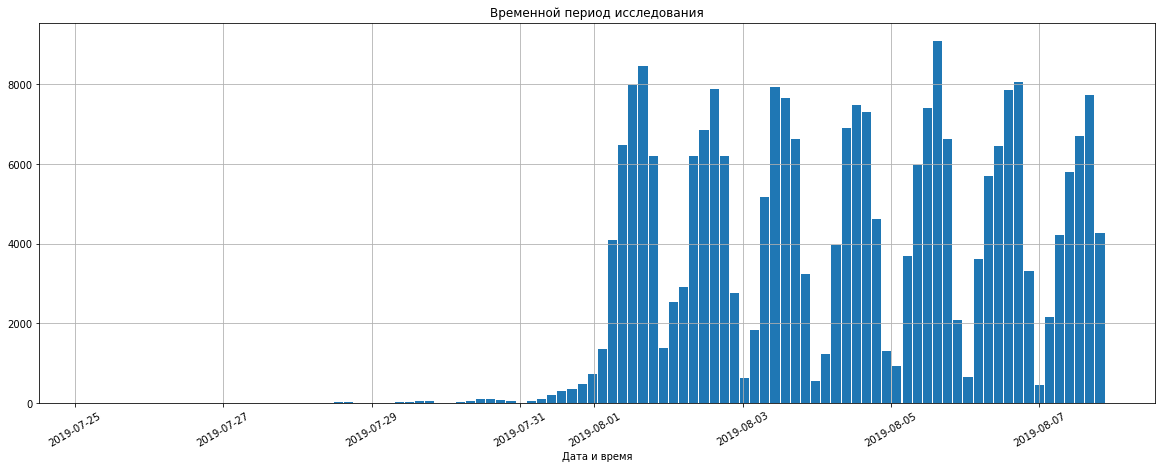

In [14]:
df["date_time"].hist(bins=100, figsize=(20,7), rwidth=0.9)
plt.title('Временной период исследования')
plt.xlabel('Дата и время')
plt.xticks(rotation=30)
plt.show;

Заметим, что данные за июль неполные. Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Возьмем период с 2019-08-01 по 2019-08-07 как исследуемый. 

In [15]:
# посчитаем количество событий и количество пользователей в df со старыми данными
events_before_filter = len(df)
users_before_filter = df['user_id'].nunique()

# отбросим ненужные строки и посчитаем количество строк в отфильтрованном df
df = df.query('date >= "2019-08-01"')
events_after_filter = len(df)
users_after_filter = df['user_id'].nunique()

# отобразим изменения в df
print(f'Количество событий в старой таблице: {events_before_filter}, количество событий в новой таблице: {events_after_filter}')
print(f'Количество пользователей в старой таблице: {users_before_filter}, количество пользователей в новой таблице: {users_after_filter}')
print(f'Изменение количества событий: {(events_after_filter/events_before_filter) - 1:.2%}')
print(f'Изменение количества пользователей: {(users_after_filter/users_before_filter) - 1:.2%}')

# проверим пользователей 3 экспериментальных групп
display(df.groupby('group').agg({'user_id':'count'}))
display(df.groupby('group').agg({'user_id':'nunique'}))


Количество событий в старой таблице: 243713, количество событий в новой таблице: 240887
Количество пользователей в старой таблице: 7551, количество пользователей в новой таблице: 7534
Изменение количества событий: -1.16%
Изменение количества пользователей: -0.23%


,user_id
group,
246,79302
247,77022
248,84563


,user_id
group,
246,2484
247,2513
248,2537


C 3 экспериментальными группами все впорядке. 

### Анализ воронки событий

In [16]:
# посмотрим какие есть события и как часто они встречаются
events = df.groupby('event')\
           .agg({'user_id':'count'})\
           .sort_values(by='user_id', ascending=False)\
           .rename(columns={'user_id':'total'})\
           .reset_index()
            
events['ratio, %'] = events['total']/len(df)*100
display(events)

,event,total,"ratio, %"
0,MainScreenAppear,117328,48.71
1,OffersScreenAppear,46333,19.23
2,CartScreenAppear,42303,17.56
3,PaymentScreenSuccessful,33918,14.08
4,Tutorial,1005,0.42


* MainScreenAppear. Главную страницу приложения пользователи увидели 117328 раз.
* OffersScreenAppear. Предложение товаров пользователи увидели 46333 раза.
* CartScreenAppear. Корзину пользователи увидели 42303 раза.
* PaymentScreenSuccessful. Страничку об успешной оплате пользователи увидели 33918 раз.
* Tutorial. Туториал пользователи увидели 117328 раз.

In [17]:
# посчитаем сколько пользователей совершили эти события и долю
users = df.groupby('event')\
           .agg({'user_id':'nunique'})\
           .sort_values(by='user_id', ascending=False)\
           .rename(columns={'user_id':'total'})\
           .reset_index()
            
users['ratio, %'] = users['total']/df['user_id'].nunique()*100
display(users)

,event,total,"ratio, %"
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


* MainScreenAppear. Главную страницу приложения увидело 7419 пользователей.
* OffersScreenAppear. Предложение товаров увидело 4593 пользователя.
* CartScreenAppear. Корзину увидело 3734 пользователей.
* PaymentScreenSuccessful. Страничку об успешной оплате увидело 3539 пользователей.
* Tutorial. Туториал увидело 840 пользователей.

Пользователи сначала видят главную страницу, далее страницу с предложениями, затем переходят в корзину и при оплате видят страничку с успешной оплатой. Туториал пользователи обычно не смотрят в связи с интуитивно понятным интерфейсом. Уберем эту строку из цепочки.

In [18]:
# уберем из users строку с туториалом и столбец 'ratio, %'
users = users.query('event != "Tutorial"')
users = users.drop('ratio, %', axis=1)

# посчитаем конверсию и конверсию в шаг
users['CR, %'] = users['total'].div(users.loc[0, 'total'], axis=0) * 100
users['CR per step, %'] = users['total'] / np.roll(users['total'], shift=1) * 100
users.loc[0, 'CR per step, %'] = 100.00
display(users)

,event,total,"CR, %","CR per step, %"
0,MainScreenAppear,7419,100.00,100.00
1,OffersScreenAppear,4593,61.91,61.91
2,CartScreenAppear,3734,50.33,81.30
3,PaymentScreenSuccessful,3539,47.70,94.78


Как видим больше всего пользователей мы теряем в самый первый шаг - 38.09%. До оплаты доходят только 47.7% пользователей.

### Анализ A/A/B-теста

In [19]:
# посчитаем количество пользователей 3 экспериментальных групп
display(df.groupby('group').agg({'user_id':'nunique'}))

,user_id
group,
246,2484
247,2513
248,2537


Проверим, находят ли статистические критерии разницу между выборками 246 и 247 (А/А). Для этого сгруппируем события для каждой группы. Далее зададим функцию, которая будет проверять гипотезы о равенство долей для каждого события. У нас множественный тест, поэтому зададим поправку Бонферрони: так-как события 4, то для А/А теста будет 4 гипотезы (alpha / 4). Для A/B - 12 гипотез (alpha / 12):  по 4 событиями мы сравниваем 246 с 248, 247 с 248, бъединенную 246 и 247 с 248.

In [20]:
# группируем данные
test = (df.groupby(['event', 'group'])\
                   .agg({'user_id': 'nunique'})\
                   .rename(columns={'user_id' : 'total'})\
                   .sort_values(by=['group','total'], ascending=False))\
                   .reset_index()

# избавляемся от ненужного события
test = test.query('event != "Tutorial"')
display(test)

,event,group,total
0,MainScreenAppear,248,2493
1,OffersScreenAppear,248,1531
2,CartScreenAppear,248,1230
3,PaymentScreenSuccessful,248,1181
5,MainScreenAppear,247,2476
6,OffersScreenAppear,247,1520
7,CartScreenAppear,247,1238
8,PaymentScreenSuccessful,247,1158
10,MainScreenAppear,246,2450
11,OffersScreenAppear,246,1542


In [21]:
# задаем функцию, которая будет проверять гипотезы о равенство долей для каждого события с поправкой Бонферрони
def z_test(df1, df2, event, alpha, n):
    
    # уровень статистической значимости c поправкой Бонферрони
    bonferroni_alpha = alpha / n
 
    # число пользователей в группе 1 и группе 2:
    n_users = np.array([df1['user_id'].nunique(), 
                        df2['user_id'].nunique()])

    # число пользователей, совершивших событие в группе 1 и группе 2
    success = np.array([df1[df1['event'] == event]['user_id'].nunique(), 
                        df2[df2['event'] == event]['user_id'].nunique()])

    # пропорции успехов в группах:
    p1 = success[0]/n_users[0]
    p2 = success[1]/n_users[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (n_users[0] + n_users[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference /  np.sqrt(p_combined * (1 - p_combined) * (1/n_users[0] + 1/n_users[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2   #тест двусторонний, удваиваем результат
    
    print('Событие:', event)
    print('p-value: ', p_value)

    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

#### A/A тест. Сравнение 246 и 247 группы

Сформулируем гипотезы:

* $H_{0}$: различий в долях конкретного события между группами нет
* $H_{1}$: различия в долях конкретного события между группами есть

In [22]:
for event in test['event'].unique():
    z_test(df[df['group'] == 246], df[df['group'] == 247], event, 0.05, 4)
    print()

Событие: MainScreenAppear
p-value:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-value:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-value:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-value:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Между долями разницы нет по всем событиям, следовательно можно проводить A/B тест.

#### A/B тест. Сравнение 246 и 248 группы

Сформулируем гипотезы:

* $H_{0}$: различий в долях конкретного события между группами нет
* $H_{1}$: различия в долях конкретного события между группами есть

In [23]:
for event in test['event'].unique():
    z_test(df[df['group'] == 246], df[df['group'] == 248], event, .05, 12)
    print()

Событие: MainScreenAppear
p-value:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-value:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-value:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-value:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Между долями разницы нет по всем событиям.

#### A/B тест. Сравнение 247 и 248 группы

Сформулируем гипотезы:

* $H_{0}$: различий в долях конкретного события между группами нет
* $H_{1}$: различия в долях конкретного события между группами есть

In [24]:
for event in test['event'].unique():
    z_test(df[df['group'] == 247], df[df['group'] == 248], event,.05, 12)
    print()

Событие: MainScreenAppear
p-value:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-value:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-value:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-value:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Между долями разницы нет по всем событиям.

#### A/B тест. Сравнение 246+247 и 248 группы

Сформулируем гипотезы:

* $H_{0}$: различий в долях конкретного события между группами нет
* $H_{1}$: различия в долях конкретного события между группами есть

In [25]:
for event in test['event'].unique():
    z_test(df[df['group'] != 248], df[df['group'] == 248], event,.05,12)
    print()

Событие: MainScreenAppear
p-value:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-value:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-value:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-value:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Между долями разницы нет по всем событиям.

### Общий вывод

**Воронка событий**

После анализа поведения пользователей мы смогли постоить воронку событий:

* MainScreenAppear. Главную страницу приложения увидело 7419 пользователей.
* OffersScreenAppear. Предложение товаров увидело 4593 пользователя.
* CartScreenAppear. Корзину увидело 3734 пользователей.
* PaymentScreenSuccessful. Страничку об успешной оплате увидело 3539 пользователей.
* Tutorial. Туториал увидело 840 пользователей.

Мы исключили событие туториал при анализе A/A/B-теста, так-как далеко не все пользователи пользуются данной возможностью.

**Анализ A/A/B теста**

В тесте участовали:

* 246 - группа A, 2484 человека. 
* 247 - группа A, 2513 человек.
* 248 - группа B, 2537 человек.

Мы провели множественное сравнение по каждому событию и не обнаружили статистически значимой разницы между группами, поэтому мы утверждаем, что изменение шрифта никак на пользователей не повлияло.